In [1]:
import pandas as pd
import torch
import re
import numpy as np
from transformers import EsmTokenizer, EsmModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch import nn
from torch.utils.data import DataLoader, Dataset
from Bio.PDB import PDBParser, PDBList, Select, DSSP
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB.Polypeptide import PPBuilder, is_aa
import os
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from Bio.SeqUtils import seq1

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


/root/miniconda3/envs/gazi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("skempi_v2.csv",sep=';')  # should have: sequence, position, wild, mutant, ddg

# Load the ESM model and tokenizer from HuggingFace
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
#tokenizer = EsmTokenizer.from_pretrained("facebook/esm1v_t33_650M_UR90S_1")
#model = EsmModel.from_pretrained("facebook/esm1v_t33_650M_UR90S_1")
#tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
#model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 320, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
    

In [16]:
def get_chain_sequence(pdb_id, chain_id):

    pdb_file = "PDBs/" + pdb_id + ".pdb"
    #print(pdb_file)
    #pdb_file = pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format="pdb")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file)
    
    for model in structure:
        for chain in model:
            if chain.id == chain_id:
                ppb = PPBuilder()
                sequence = ""
                for pp in ppb.build_peptides(chain):
                    sequence += str(pp.get_sequence())
                return sequence
    return None
def get_esm_embedding(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    token_embeddings = outputs.last_hidden_state.squeeze(0)
    mask = inputs["attention_mask"].squeeze(0).bool()
    avg_embedding = token_embeddings[mask].mean(dim=0).cpu().numpy()
    return avg_embedding

pdb_dir = "PDBs/"
#os.makedirs(pdb_dir, exist_ok=True)
pdbl = PDBList()


In [4]:
def get_distance_contacts(pdb_file, chain_id, mutation_pos, contact_cutoff=10.0, num_contacts=20):
    """
    Extract distance contacts for a specific residue position from PDB structure.
    
    Args:
        pdb_file: Path to PDB file
        chain_id: Chain ID of interest
        mutation_pos: Position of mutation (1-indexed)
        contact_cutoff: Maximum distance to consider as contact (Angstroms)
        num_contacts: Number of closest contacts to include
    
    Returns:
        contact_features: Dictionary with contact information
    """
    # Parse PDB structure
    parser = PDBParser(QUIET=True)
    try:
        structure = parser.get_structure("protein", pdb_file)
    except Exception as e:
        print(f"Error parsing PDB file {pdb_file}: {e}")
        return None
    
    # Get chain
    try:
        chain = structure[0][chain_id]
    except KeyError:
        print(f"Chain {chain_id} not found in PDB {pdb_file}")
        return None
    
    # Get mutated residue
    try:
        mutated_res = chain[mutation_pos]
    except KeyError:
        print(f"Residue position {mutation_pos} not found in chain {chain_id}")
        return None
    
    # Calculate CA-CA distances to all other residues
    distances = []
    for residue in chain:
        if not is_aa(residue) or residue.id[0] != " ":  # Skip non-standard residues
            continue
        
        if residue.id[1] == mutation_pos:  # Skip the mutation position itself
            continue
        
        # Try to get CA atoms
        try:
            ca_mut = mutated_res["CA"]
            ca_other = residue["CA"]
            distance = ca_mut - ca_other
            distances.append((residue.id[1], residue.resname, distance))
        except KeyError:
            continue
    
    # Sort by distance
    distances.sort(key=lambda x: x[2])
    
    # Get closest contacts within cutoff
    close_contacts = [(pos, res, dist) for pos, res, dist in distances if dist <= contact_cutoff]
    
    # Extract features
    contact_features = {
        'num_contacts_within_cutoff': len(close_contacts),
        'mean_contact_distance': np.mean([dist for _, _, dist in close_contacts]) if close_contacts else contact_cutoff,
        'min_contact_distance': min([dist for _, _, dist in close_contacts]) if close_contacts else contact_cutoff,
    }
    
    # Get residue type counts in contact shell
    aa_types = set(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
                    'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
                    'THR', 'TRP', 'TYR', 'VAL'])
    
    for aa in aa_types:
        contact_features[f'contact_count_{aa}'] = sum(1 for _, res, _ in close_contacts if res == aa)
    
    # Get closest contacts (up to num_contacts)
    closest_contacts = close_contacts[:min(num_contacts, len(close_contacts))]
    
    # Pad if needed
    while len(closest_contacts) < num_contacts:
        closest_contacts.append((0, 'XXX', contact_cutoff))
    
    # Add individual contact features
    for i, (pos, res, dist) in enumerate(closest_contacts[:num_contacts]):
        contact_features[f'contact_{i}_pos'] = pos
        # One-hot encoding for residue type
        for aa in aa_types:
            contact_features[f'contact_{i}_{aa}'] = 1 if res == aa else 0
        contact_features[f'contact_{i}_dist'] = dist
    
    return contact_features

# Function to get secondary structure features
def get_secondary_structure(pdb_file, chain_id, mutation_pos):
    """
    Get secondary structure features for the mutation position.
    
    Args:
        pdb_file: Path to PDB file
        chain_id: Chain ID of interest
        mutation_pos: Position of mutation (1-indexed)
    
    Returns:
        ss_features: Dictionary with secondary structure information
    """
    # Parse PDB structure
    parser = PDBParser(QUIET=True)
    try:
        structure = parser.get_structure("protein", pdb_file)
    except Exception as e:
        print(f"Error parsing PDB file {pdb_file}: {e}")
        return None
    
    # Run DSSP
    try:
        model = structure[0]
        dssp = DSSP(model, pdb_file,file_type="PDB")
        
        # Find the key for our mutation position
        key = None
        for k in dssp.keys():
            if k[0] == chain_id and k[1][1] == mutation_pos:
                key = k
                break
        
        if key is None:
            print(f"Residue {mutation_pos} not found in DSSP results")
            return {
                'ss_helix': 0,
                'ss_sheet': 0,
                'ss_loop': 1,
                'ss_acc': 0.5,  # Assume average accessibility
            }
        
        # Get secondary structure and accessibility
        ss = dssp[key][2]
        acc = dssp[key][3]
        
        # Convert to features
        ss_features = {
            'ss_helix': 1 if ss in ('H', 'G', 'I') else 0,
            'ss_sheet': 1 if ss in ('E', 'B') else 0,
            'ss_loop': 1 if ss in ('T', 'S', ' ', 'C') else 0,
            'ss_acc': acc,  # Relative accessibility
        }
        
        return ss_features
        
    except Exception as e:
        print(f"Error running DSSP: {e}")
        return {
            'ss_helix': 0,
            'ss_sheet': 0,
            'ss_loop': 1,
            'ss_acc': 0.5,  # Assume average accessibility
        }


def get_combined_features(wt_sequence, mutation, position, pdb_file, chain_id,wt):
    """Combine ESM embeddings with structure-based features."""
    # Parse mutation format

    wt = wt
    mt = mutation
    pos = position  # 1-indexed position
    
    # Verify wild-type residue

    
    # Apply mutation
    mt_sequence = wt_sequence[:pos-1] + mt + wt_sequence[pos:]
    
    # Generate ESM embeddings
    wt_embedding = get_esm_embedding(wt_sequence)
    mt_embedding = get_esm_embedding(mt_sequence)
    
    # Calculate embedding difference
    embedding_diff = mt_embedding - wt_embedding
    
    # Get structure-based features
    try:
        contact_features = get_distance_contacts(pdb_file, chain_id, pos)
        ss_features = get_secondary_structure(pdb_file, chain_id, pos)
        
        # If structure features couldn't be extracted, use dummy values
        if contact_features is None:
            # Create dummy contact features
            contact_features = {
                'num_contacts_within_cutoff': 0,
                'mean_contact_distance': 10.0,
                'min_contact_distance': 10.0,
            }
            
            # Add dummy residue type counts
            aa_types = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
                        'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
                        'THR', 'TRP', 'TYR', 'VAL']
            for aa in aa_types:
                contact_features[f'contact_count_{aa}'] = 0
            
            # Add dummy individual contacts
            num_contacts = 20  # Same as in the get_distance_contacts function
            for i in range(num_contacts):
                contact_features[f'contact_{i}_pos'] = 0
                for aa in aa_types:
                    contact_features[f'contact_{i}_{aa}'] = 0
                contact_features[f'contact_{i}_dist'] = 10.0
        
        if ss_features is None:
            ss_features = {
                'ss_helix': 0,
                'ss_sheet': 0,
                'ss_loop': 1,
                'ss_acc': 0.5,
            }
    except Exception as e:
        print(f"Error extracting structure features: {e}")
        return None
    
    # Combine all features
    structure_features = []
    
    # Add simple physicochemical features about the mutation
    # Hydrophobicity scale (Kyte-Doolittle)
    hydrophobicity = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5,
        'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8,
        'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }
    
    # Volume (Å³)
    volume = {
        'A': 88.6, 'R': 173.4, 'N': 114.1, 'D': 111.1, 'C': 108.5, 'Q': 143.8, 
        'E': 138.4, 'G': 60.1, 'H': 153.2, 'I': 166.7, 'L': 166.7, 'K': 168.6, 
        'M': 162.9, 'F': 189.9, 'P': 112.7, 'S': 89.0, 'T': 116.1, 'W': 227.8, 
        'Y': 193.6, 'V': 140.0
    }
    
    # Add mutation-specific features
    structure_features.append(hydrophobicity.get(wt, 0))
    structure_features.append(hydrophobicity.get(mt, 0))
    structure_features.append(hydrophobicity.get(mt, 0) - hydrophobicity.get(wt, 0))
    structure_features.append(volume.get(wt, 0))
    structure_features.append(volume.get(mt, 0))
    structure_features.append(volume.get(mt, 0) - volume.get(wt, 0))
    
    # Add contact features
    for key, value in contact_features.items():
        structure_features.append(value)
    
    # Add secondary structure features
    for key, value in ss_features.items():
        structure_features.append(value)
    
    # Convert structure features to numpy array
    structure_features = np.array(structure_features, dtype=np.float32)
    
    # Combine with embedding difference
    combined_features = np.concatenate([embedding_diff, structure_features])
    
    return combined_features


In [17]:
feat = []
labels = []

import re
for idx, row in df.iterrows():
    if ',' in row['Mutation(s)_cleaned']:
        continue
    pdb_id = row['#Pdb'][0:4]
    chain_id = row['Mutation(s)_cleaned'][1]
    sequence = get_chain_sequence(pdb_id, chain_id)
    #break
    
    position = re.search(r'[A-Za-z](\d+)[A-Za-z]', row['Mutation(s)_cleaned']).group(1)
    #pos = int(position) - 1
    pos = int(position)
    #pdb_id = pdb_id.lower()
    
    pdb_file = "PDBs/" + pdb_id + ".pdb"


    feature_vector = get_combined_features(sequence,row['Mutation(s)_cleaned'][-1],pos,pdb_file,chain_id,row['Mutation(s)_cleaned'][0])
    ddg = ((8.314/4184)*(273.15 + 25.0)* np.log(row['Affinity_mut_parsed'])) - ((8.314/4184)*(273.15 + 25.0)* np.log(row['Affinity_wt_parsed']))
    if pd.isna(ddg):
        ddg = 0
    
    

    feat.append(feature_vector)
    labels.append(ddg)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residue CYS het=  resseq=115 icode= >
Error running DSSP: Structure/DSSP mismatch at <Residu

In [18]:
X = np.array(feat)
y = np.array(labels)
print(y.shape)
print(df.shape)

(5112,)
(7085, 29)


In [35]:
class DdGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Deep learning model
class DdGPredictor(nn.Module):
    def __init__(self, input_dim):
        super(DdGPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # Add batch normalization
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Add batch normalization
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),   # Add batch normalization
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, clip_value=1.0):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features = features.to(device)
            
            labels = labels.to(device)
            
            
            optimizer.zero_grad()
            outputs = model(features)
            
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            #print(f"running_loss: {running_loss}")
        
        train_loss = running_loss / len(train_loader)
        #print(f"Length train_loader: {len(train_loader)}")
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                
                features = features.to(device)
                labels = labels.to(device)
                #print(labels)
                outputs = model(features)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12)
print(y_train.shape)

(3271,)


793
Training model...
Epoch 1/100, Train Loss: 3.56550916, Val Loss: 3.08972365
Epoch 2/100, Train Loss: 2.86273417, Val Loss: 2.81508535
Epoch 3/100, Train Loss: 2.42560614, Val Loss: 2.69949201
Epoch 4/100, Train Loss: 2.13022506, Val Loss: 2.52914028
Epoch 5/100, Train Loss: 1.78625073, Val Loss: 2.52663260
Epoch 6/100, Train Loss: 1.62733622, Val Loss: 2.33261039
Epoch 7/100, Train Loss: 1.37536794, Val Loss: 2.21883247
Epoch 8/100, Train Loss: 1.23057198, Val Loss: 2.27225489
Epoch 9/100, Train Loss: 1.10569395, Val Loss: 2.15716205
Epoch 10/100, Train Loss: 1.02894683, Val Loss: 2.16983770
Epoch 11/100, Train Loss: 0.93529837, Val Loss: 2.14825867
Epoch 12/100, Train Loss: 0.91159855, Val Loss: 2.01221050
Epoch 13/100, Train Loss: 0.83964528, Val Loss: 1.90702360
Epoch 14/100, Train Loss: 0.76881708, Val Loss: 1.90721091
Epoch 15/100, Train Loss: 0.79582880, Val Loss: 1.92261898
Epoch 16/100, Train Loss: 0.70918250, Val Loss: 1.83330389
Epoch 17/100, Train Loss: 0.65641977, Val L

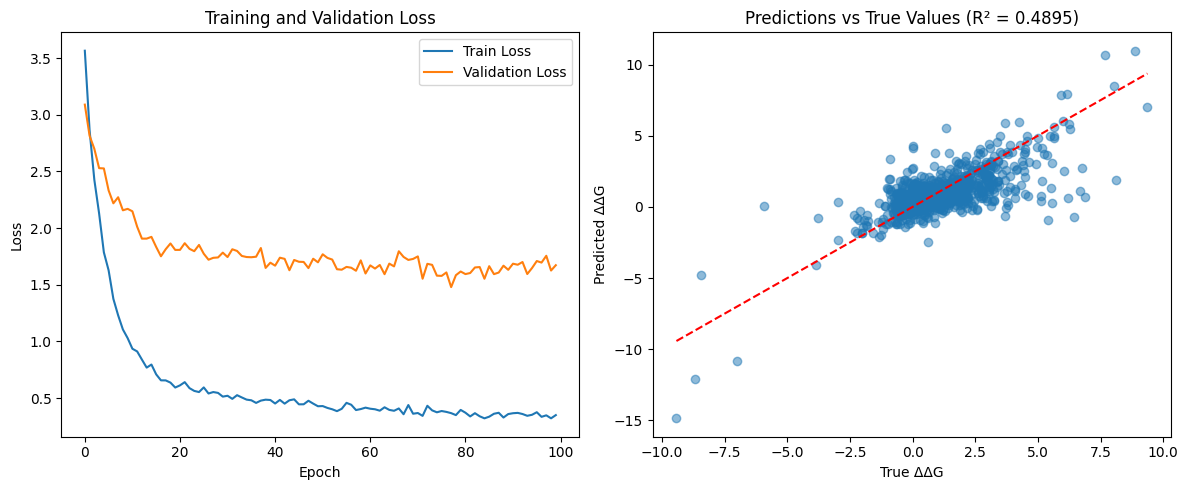

In [38]:

    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Create dataloaders
    train_dataset = DdGDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = DdGDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = DdGDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model
    input_dim = X_train.shape[1]  # ESM embedding dimension
    print(input_dim)
    model = DdGPredictor(input_dim).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
    
    # Train model
    print("Training model...")
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=100
    )
    
    # Evaluate model
    print("Evaluating model...")
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features)
            predictions = outputs.squeeze().cpu().numpy()
            y_pred.extend(predictions)
            y_true.extend(labels.numpy())
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Test Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {r2:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot predictions vs true values
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('True ΔΔG')
    plt.ylabel('Predicted ΔΔG')
    plt.title(f'Predictions vs True Values (R² = {r2:.4f})')
    
    plt.tight_layout()
    plt.savefig('ddg_prediction_results.png')
    plt.show()